In [78]:
"""
input vector array
output: 
    1. sorted vector of unique vals  
    2. location of them with respect to indeces
"""
function where_unique(x)
    loc_unique = zeros(size(x))
    uniques = sort(unique(x))
    for i in 1:length(uniques)
        idx = findall(x .== uniques[i])
        loc_unique[idx] .= i
    end
    return uniques,loc_unique
end

"""
No accumarray function in Julia. Built own to help get transition matrix count
input: Vector of locations of values 0 or 1. 
output: 2x2 transition matrix of count (Outputs a NxN array of the # of transitions in terms of indices)
"""
function trans_matrix_count(x)
    tMatrix_count = zeros(2,2)
    hold = x[1:end-1]*2 .- x[2:end]
    tMatrix_count[1,1] = length(findall(hold.==1))
    tMatrix_count[1,2] = length(findall(hold.==0))
    tMatrix_count[2,1] = length(findall(hold.==3))
    tMatrix_count[2,2] = length(findall(hold.==2))
    return tMatrix_count
end


using Distributions
using Statistics
using StatsBase
using Random
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [96]:
"""
Inputs: 
    X:  time series data (unit per period)
    LT: lead time (# periods)
    N:  number of lead time replications
Outputs:
    Q:  
    LTD: 
"""
function MarkovBootstrap(X,LT,N,print_output=false,show_plot=false)

    
    ## Create Demand On/Off Vector
    Dmd = X.>0; # Logical vector of demand
    Dmd = convert(Array{Int64},Dmd)
    DmdVal = X[X.>0]; # consolidated demand oberservations
    State = [0 1];     # states are [NODMD DMD]
    ####### Get Transition Matrix
    # if there is demand every period build the correct transition matrix
    if !(0 in Dmd)
        P = [0 0;
            0 1]
    else
        # Two State (zero vs. non-zero) matrix creation
        u,n = where_unique(Dmd) # u: The unqiue #s observed. #n: idx of u that forms dem. dem = u(n)
        z = length(u) # # of unique observations
        F = trans_matrix_count(n) # Create count transition matrix. Outputs a NxN array of the # of transitions in terms of indices.
        P = F./sum(F,dims=2); # Probability transition matrix. States: No Demand , Demand
    end
    
    ##### Generate LTD
    # Generate your first forecast based on last actually observed demand value from the original data set.
    r_num = rand(N) #gen random numbers of length replication
    greater = r_num .> P[Dmd[end]+1,1] #takes transition probs and checks where rand numbers are greater than first prob (which is prob of new state being 0)
    greater = convert(Array{Int64},greater) #convert because resulting array was bit/binary array
    DmdForecast = hcat(greater, zeros(N,LT-1))
    DmdForecast = convert(Array{Int64},DmdForecast)
    ##### Create demand for the next periods up to lead time. based on probs of previously observed period
    #loop through similar process above
    for j in 2:LT
        r_num = rand(N)
        next_rand = (r_num .> P[DmdForecast[:,LT-1].+1,1])
        next_rand = convert(Array{Int64},next_rand)
        DmdForecast[:,j] = next_rand
    end
    
    NumPosDmd = sum(DmdForecast,dims=2)
    
    #Turn the 0 1 into observed values
    for i in 1:N
        # Take a random sample, from the demand values, take the number of sameples required for that row, with replacement. 
        # Put them in the appropraiate rows and columns
        DmdForecast[i,DmdForecast[i,:].==1] .= sample(DmdVal, NumPosDmd[i], replace=true)
    end
    
    # jitter
    for i in 1:N
        for j in 1:LT
            if DmdForecast[i,j] > 0 #if there is demand there
                k = 1 + round(DmdForecast[i,j] + rand(Normal(0,1)*sqrt(DmdForecast[i,j])))
                if k >= 0 #if jittered value is >= 0 store value
                    DmdForecast[i,j] = k #store new jitter value
                end
            end
        end
    end
    
    LTD = sum(DmdForecast,dims=2)
    
    #### Check up on quantiles on how they are different than MATLAB
    
    normal_dist = Distributions.Normal(mean(LTD),std(LTD))
    
    Q = quantile(sort(reshape(LTD,size(LTD)[1])),0.75)
    
    if print_output == true
        println("Markov Bootstrap 75th Percentile: ", Q)
        println("Normal 95th percentile: ", string(Statistics.quantile(normal_dist,0.75)))
        #### Not sure what truncated normal is 
        #my edit
        #println("Truncated Normal 95th Percentile: ", string()))
        #disp(['Truncated Normal 95th Percentile: ' num2str(icdf(pdNt,0.95))])
    end
    
    if show_plot == true
        histogram(LTD_test,title="Lead Time Demand Distribution", xlabel="Lead Time Demand", ylabel="Number of Scenarios",
            label = "LTD")
        vline!([Q_test],label="75th Quantile")
    end
    
    return LTD,Q
end

MarkovBootstrap

In [128]:
x = [1, 0, 9, 8, 0, 0, 7, 7, 0, 9, 0, 8, 0, 0]
dem_vals = x[x.>0]
LTD_test,Q_test = MarkovBootstrap(x,50,100,true)
@show(LTD_test)

DmdVal = [1, 9, 8, 7, 7, 9, 8]
(P, F) = ([0.3333333333333333 0.6666666666666666; 0.7142857142857143 0.2857142857142857], [2.0 4.0; 5.0 2.0])
DmdForecast = [0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1; 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0; 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0; 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0; 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1; 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1; 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0; 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1; 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 

100×1 Array{Int64,2}:
 290
 215
 267
 285
 310
 273
 262
 317
 271
 273
 296
 318
 275
   ⋮
 246
 265
 263
 224
 259
 245
 336
 281
 265
 279
 320
 251

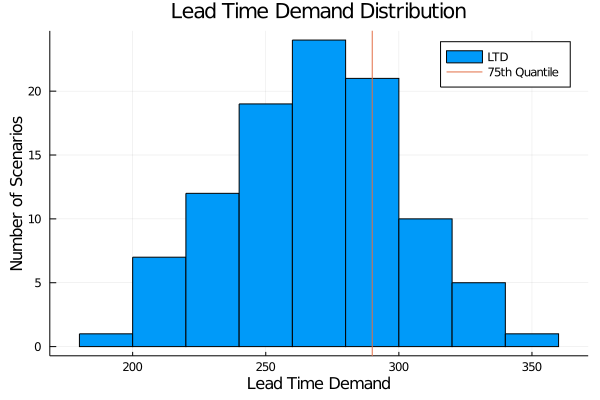

In [130]:
histogram(LTD_test,title="Lead Time Demand Distribution", xlabel="Lead Time Demand", ylabel="Number of Scenarios",
            label = "LTD")
vline!([Q_test],label="75th Quantile")

In [70]:
histogram(LTD,'Normalization','pdf','DisplayName','MarkovBootstrap')
histogram(LTD)
xRng = xlim;
Xspan = xRng(1):.01:xRng(2);
plot(Xspan,pdf(pdN,Xspan),'r--','DisplayName','Normal')
plot(Xspan,pdf(pdNt,Xspan),'k--','DisplayName','Truncated Normal')
xline(quantile(LTD,.75),'-.','75th Quantile','LabelVerticalAlignment','middle','LabelOrientation','horizontal','DisplayName','75th Quantile');
xlabel('Lead Time Demand')
ylabel('Number of Scenarios')
title('Lead Time Demand Distribution')
legend('show','Location','northeast')

DmdVal = [1, 9, 892, 7, 729, 9, 8]
(P, F) = ([0.3333333333333333 0.6666666666666666; 0.7142857142857143 0.2857142857142857], [2.0 4.0; 5.0 2.0])
DmdForecast = [0 1 1 1 0; 1 1 1 1 0; 0 0 1 1 1; 1 1 1 0 0; 1 1 1 1 0; 1 1 1 1 0; 1 1 1 1 0; 1 1 0 1 0; 0 1 1 1 0; 1 1 1 0 1]
DmdForecast = [0 9 892 9 0; 729 9 9 1 0; 0 0 892 8 9; 8 9 1 0 0; 1 1 1 7 0; 729 729 729 1 0; 9 892 892 892 0; 892 9 0 7 0; 0 7 1 7 0; 892 1 729 0 892]


([917; 728; … ; 16; 2571], 1920.5)

In [75]:
sort(LTD_test,dims=1)

10×1 Array{Int64,2}:
   12
   16
   23
  728
  893
  917
  923
 2253
 2571
 2729

In [121]:
@doc vline


```
vline(x)
vline!(x)
```

Draw vertical lines at positions specified by the values in the AbstractVector `x`

# Example

```julia-repl
julia> vline([-1,0,2])
```
